In [1]:
#| default_exp app_v1

### Parkinsons Disease Progression Predictions

Competition [Link](https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction/overview)

Submissions are evaluated on SMAPE between forecasts and actual values. We define SMAPE = 0 when the actual and predicted values are both 0.

For each patient visit where a protein/peptide sample was taken you will need to estimate both their UPDRS scores for that visit and predict their scores for any potential visits 6, 12, and 24 months later. Predictions for any visits that didn't ultimately take place are ignored.

You must submit to this competition using the provided python time-series API, which ensures that models do not peek forward in time. To use the API, follow this template in Kaggle Notebooks:

```Python
import amp_pd_peptide
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    sample_prediction_df['rating'] = np.arange(len(sample_prediction))  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions

Dataset Description

The goal of this competition is to predict the course of Parkinson's disease (PD) using protein abundance data. The complete set of proteins involved in PD remains an open research question and any proteins that have predictive value are likely worth investigating further. The core of the dataset consists of protein abundance values derived from mass spectrometry readings of cerebrospinal fluid (CSF) samples gathered from several hundred patients. Each patient contributed several samples over the course of multiple years while they also took assessments of PD severity.

This is a time-series code competition: you will receive test set data and make predictions with Kaggle's time-series API.

Files
-----

**train\_peptides.csv** Mass spectrometry data at the peptide level. Peptides are the component subunits of proteins.

*   `visit_id` - ID code for the visit.
*   `visit_month` - The month of the visit, relative to the first visit by the patient.
*   `patient_id` - An ID code for the patient.
*   `UniProt` - [The UniProt ID code](https://www.uniprot.org/id-mapping) for the associated protein. There are often several peptides per protein.
*   `Peptide` - The sequence of amino acids included in the peptide. See [this table](https://en.wikipedia.org/wiki/Amino_acid#Physicochemical_properties_of_amino_acids) for the relevant codes. Some rare annotations may not be included in the table. The test set may include peptides not found in the train set.
*   `PeptideAbundance` - The frequency of the amino acid in the sample.

**train\_proteins.csv** Protein expression frequencies aggregated from the peptide level data.

*   `visit_id` - ID code for the visit.
*   `visit_month` - The month of the visit, relative to the first visit by the patient.
*   `patient_id` - An ID code for the patient.
*   `UniProt` - [The UniProt ID code](https://www.uniprot.org/id-mapping) for the associated protein. There are often several peptides per protein. The test set may include proteins not found in the train set.
*   `NPX` - Normalized protein expression. The frequency of the protein's occurrence in the sample. May not have a 1:1 relationship with the component peptides as some proteins contain repeated copies of a given peptide.

**train\_clinical\_data.csv**

*   `visit_id` - ID code for the visit.
*   `visit_month` - The month of the visit, relative to the first visit by the patient.
*   `patient_id` - An ID code for the patient.
*   `updrs_[1-4]` - The patient's score for part N of the [Unified Parkinson's Disease Rating Scale](https://www.movementdisorders.org/MDS/MDS-Rating-Scales/MDS-Unified-Parkinsons-Disease-Rating-Scale-MDS-UPDRS.htm). Higher numbers indicate more severe symptoms. Each sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.
*   `upd23b_clinical_state_on_medication` - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.

**supplemental\_clinical\_data.csv** Clinical records without any associated CSF samples. This data is intended to provide additional context about the typical progression of Parkinsons. Uses the same columns as **train\_clinical\_data.csv**.

**example\_test\_files/** Data intended to illustrate how the API functions. Includes the same columns delivered by the API (ie no updrs columns).

**amp\_pd\_peptide/** Files that enable the API. Expect the API to deliver all of the data (less than 1,000 additional patients) in under five minutes and to reserve less than 0.5 GB of memory. A brief demonstration of what the API delivers [is available here](https://www.kaggle.com/code/sohier/basic-api-demo).

**public\_timeseries\_testing\_util.py** An optional file intended to make it easier to run custom offline API tests. See the script's docstring for details.

#### Imports

In [2]:
#| export
from fastai.tabular.all import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
#| export
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

#### Downloading Datasets

In [4]:
#| export
comp = 'amp-parkinsons-disease-progression-prediction'
path = setup_comp(comp, install='fastai')

In [5]:
#| export
df_train_proteins = pd.read_csv(path/"train_proteins.csv", low_memory=False)
df_train_clinical = pd.read_csv(path/"train_clinical_data.csv", low_memory=False)
df_train_peptides = pd.read_csv(path/"train_peptides.csv", low_memory=False)
df_supplemental = pd.read_csv(path/"supplemental_clinical_data.csv", low_memory=False)

In [6]:
df_train_peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [7]:
df_train_proteins.head()

,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [8]:
df_train_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [9]:
#| export
df_train = df_train_proteins.merge(df_train_clinical, on=['patient_id', 'visit_id', 'visit_month'], how='left')

In [10]:
df_train.isna().sum()

visit_id                                    0
visit_month                                 0
patient_id                                  0
UniProt                                     0
NPX                                         0
updrs_1                                  9473
updrs_2                                  9473
updrs_3                                 11606
updrs_4                                114533
upd23b_clinical_state_on_medication    139328
dtype: int64

In [11]:
median_targs = df_train[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].median()

In [12]:
df_train[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']] = df_train[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']].fillna(median_targs)

In [13]:
#| export
dep_var = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

In [14]:
#| export
procs = [Categorify, FillMissing, Normalize]
cont, cat = cont_cat_split(df_train, dep_var=dep_var, max_card=1)
splits = RandomSplitter(valid_pct=0.2)(range_of(df_train))

In [15]:
#| export
to = TabularPandas(df_train, procs, cat, cont, y_names=dep_var, splits=splits)

In [16]:
to.cont_names

(#3) ['visit_month','patient_id','NPX']

In [17]:
to.cat_names

(#3) ['visit_id','UniProt','upd23b_clinical_state_on_medication']

In [18]:
# show the shape of to
to.train.xs.shape, to.train.ys.shape

((186193, 6), (186193, 4))

In [19]:
#| export
class MultiTargetSMAPE(Metric):
    def __init__(self):
        super().__init__()
    
    def reset(self):
        self.total = 0.
        self.count = 0
        
    def accumulate(self, learn):
        pred,targ = learn.pred, learn.y
        denom = torch.abs(pred) + torch.abs(targ)
        non_zero_denom = denom != 0
        num = torch.abs(pred - targ)
        smape = torch.zeros_like(num)
        smape[non_zero_denom] = num[non_zero_denom] / denom[non_zero_denom]
        self.total += smape.sum(dim=0)
        self.count += learn.y.size(0)
    
    @property
    def value(self):
        return (self.total / self.count).mean().item() * 100  # SMAPE in percentage
    
    @property
    def name(self):
        return 'multi_target_smape'


In [20]:
#| export
dls = to.dataloaders(bs=256)

In [21]:
# debug dls
dls.show_batch()

,visit_id,UniProt,upd23b_clinical_state_on_medication,visit_month,patient_id,NPX,updrs_1,updrs_2,updrs_3,updrs_4
0,16566_24,P00751,On,24.000000,16566.000446,5.908281e+05,16.0,15.0,32.0,3.0
1,41871_0,P41222,#na#,0.000001,41870.999845,3.939160e+07,10.0,5.0,25.0,0.0
2,29417_48,P20774,On,48.000000,29417.000051,2.597041e+05,1.0,9.0,10.0,0.0
3,26104_24,O15240,On,24.000000,26103.999746,4.922407e+04,9.0,6.0,30.0,0.0
4,45161_60,P04196,On,60.000001,45161.000247,2.083480e+05,17.0,7.0,15.0,1.0
5,47103_12,P02655,On,11.999999,47102.999813,2.008538e+04,5.0,6.0,16.0,0.0
6,3636_0,Q13283,#na#,0.000001,3635.999534,5.041660e+05,1.0,2.0,9.0,0.0
7,23192_6,P36222,#na#,6.000000,23192.000502,2.252910e+05,5.0,4.0,16.0,0.0
8,57009_36,P02790,#na#,36.000000,57009.000336,5.482230e+06,1.0,0.0,1.0,0.0
9,25750_48,Q8NBJ4,#na#,48.000000,25749.999982,2.409860e+04,4.0,0.0,0.0,0.0


In [22]:

dls

In [23]:
#| export
xs, ys = to.train.xs, to.train.ys
valid_xs, valid_ys = to.valid.xs, to.valid.ys

In [24]:
y = to.train.ys

In [25]:
y.min(), y.max()

(updrs_1    0.0
 updrs_2    0.0
 updrs_3    0.0
 updrs_4    0.0
 dtype: float32,
 updrs_1    33.0
 updrs_2    29.0
 updrs_3    78.0
 updrs_4    20.0
 dtype: float32)

In [26]:
#| export
learn = tabular_learner(dls, layers=[200,100], metrics=[MultiTargetSMAPE()], n_out=4, y_range=(0, 80), loss_func=mse)

SuggestedLRs(valley=0.002511886414140463)

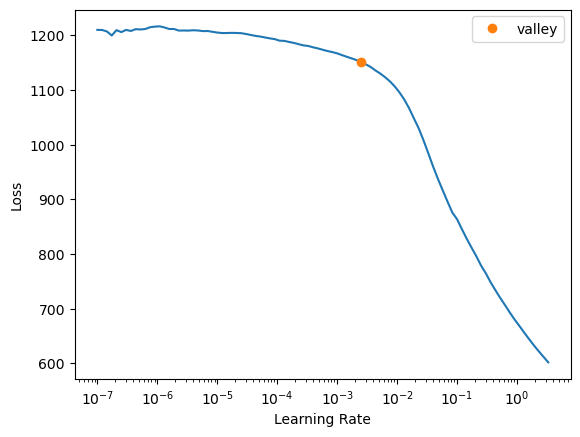

In [27]:
learn.lr_find()

In [28]:
#| export
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,multi_target_smape,time
0,18.418451,14.108479,37.907127,00:06
1,1.066332,0.394139,34.040758,00:07
2,0.476223,0.137171,32.925326,00:07


In [29]:
import nbdev
nbdev.export.nb_export('pb_parkinsons_prog.ipynb', 'app_v1')
print("export successful")

export successful
